In [1]:
# Imports
from __future__ import print_function
import time
import sys
import warnings

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

#This line is used to show all the attributes of the tables. 
#This will show upto 2000 columns per table
pd.set_option('display.max_columns', 2000) 

# machine learning
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import skew
from sklearn.metrics import accuracy_score, mean_squared_error
from xgboost import XGBRegressor

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
train = pd.read_csv('AmesDummiesOrdinal.csv', index_col=0)

In [3]:
train.shape

(1458, 186)

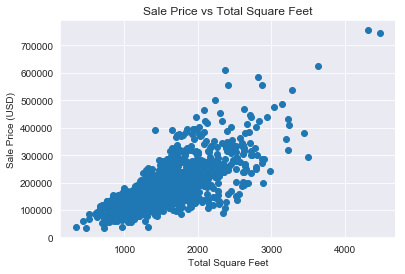

In [4]:
sns.set_style('darkgrid')
plt.scatter(train['TotalSF'], train['SalePrice'])
plt.xlabel('Total Square Feet')
plt.ylabel('Sale Price (USD)')
plt.title('Sale Price vs Total Square Feet')   
plt.show()

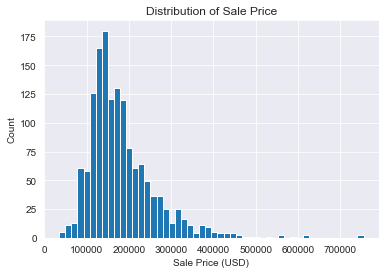

In [5]:
plt.hist(train['SalePrice'], bins = 50)
plt.xlabel('Sale Price (USD)')
plt.ylabel('Count')
plt.title('Distribution of Sale Price')   
plt.show()

In [ ]:
'''PureCategorical = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
                  'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Foundation', 'MasVnrType', 'Heating', 'CentralAir', 'Electrical',
                  'GarageType', 'SaleType','SaleCondition']
QuesCategorical = ['LotShape', 'Utilities']
OrdCategorical = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
                 'PavedDrive', 'PoolQC','Fence']
JointFeatures = ['Condition1', 'Condition2', 'Exterior1st', 'Exterior2nd']
Numerical = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtScore', 'TotalBsmtSF', 'TotalSF',
            'PctLowQual', 'AboveGroundPct', 'TotalBath', 'Bedroom', 'Kitchen', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
            'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
            'MiscVal', 'MoSold', 'YrSold', 'SalePrice']'''

In [6]:
corr = train.corr()

In [7]:
corr_df = pd.DataFrame(corr['SalePrice'].values,
                  index=[corr.columns.values])
corr_df.columns = ['SalePrice']

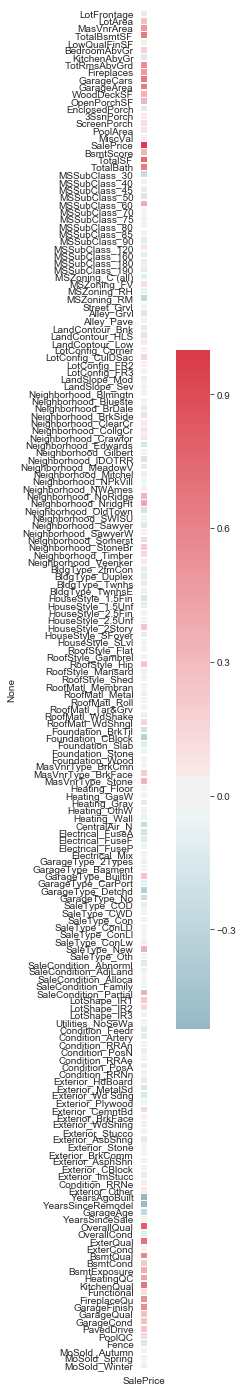

In [8]:
f, ax = plt.subplots(figsize=(10,25))
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_df, mask=mask, cmap=cmap, 
            yticklabels=corr.columns.values,
            center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Text(0.5, 0, 'Correlation')

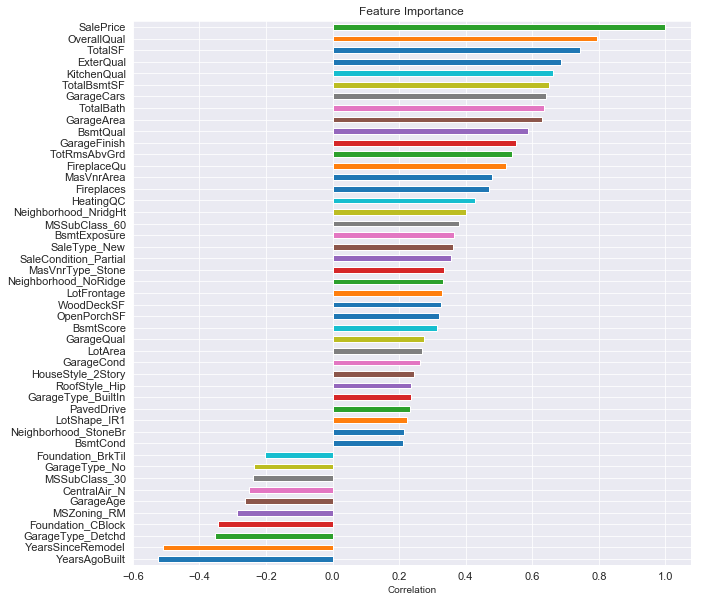

In [9]:
plt.figure(figsize=(10,10))
c = pd.Series(corr['SalePrice'])
pos = c[(corr['SalePrice'] > 0.2) | (corr['SalePrice'] < -0.2)].sort_values()
# c.plot(kind="barh", fontsize = 11)
pos.plot(kind='barh', fontsize = 11)
plt.title('Feature Importance')
plt.xlabel('Correlation')

Text(0.5, 0, 'Correlation')

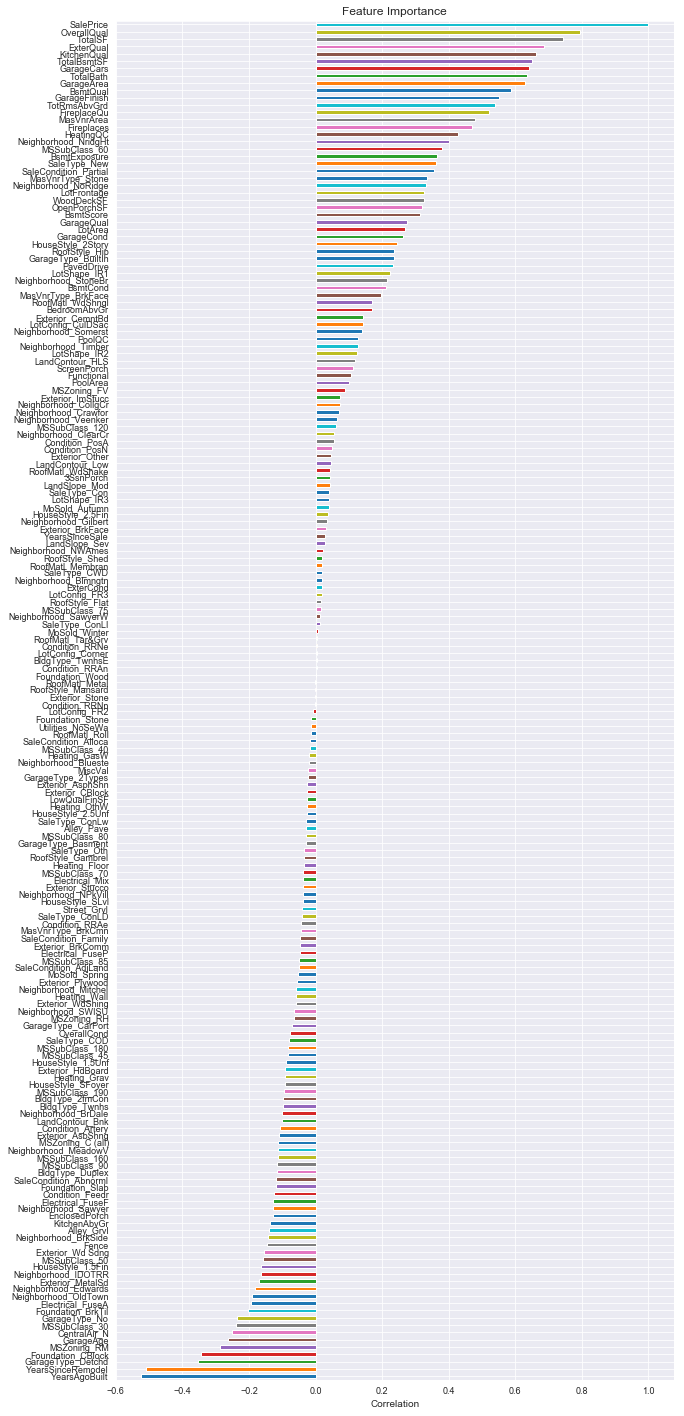

In [18]:
plt.figure(figsize=(10,25))
c = pd.Series(corr['SalePrice'])
pos = c[corr['SalePrice'] != 0].sort_values()
pos.plot(kind='barh', fontsize = 9)
plt.title('Feature Importance')
plt.xlabel('Correlation')

### Heatmaps with OrdinalDummies

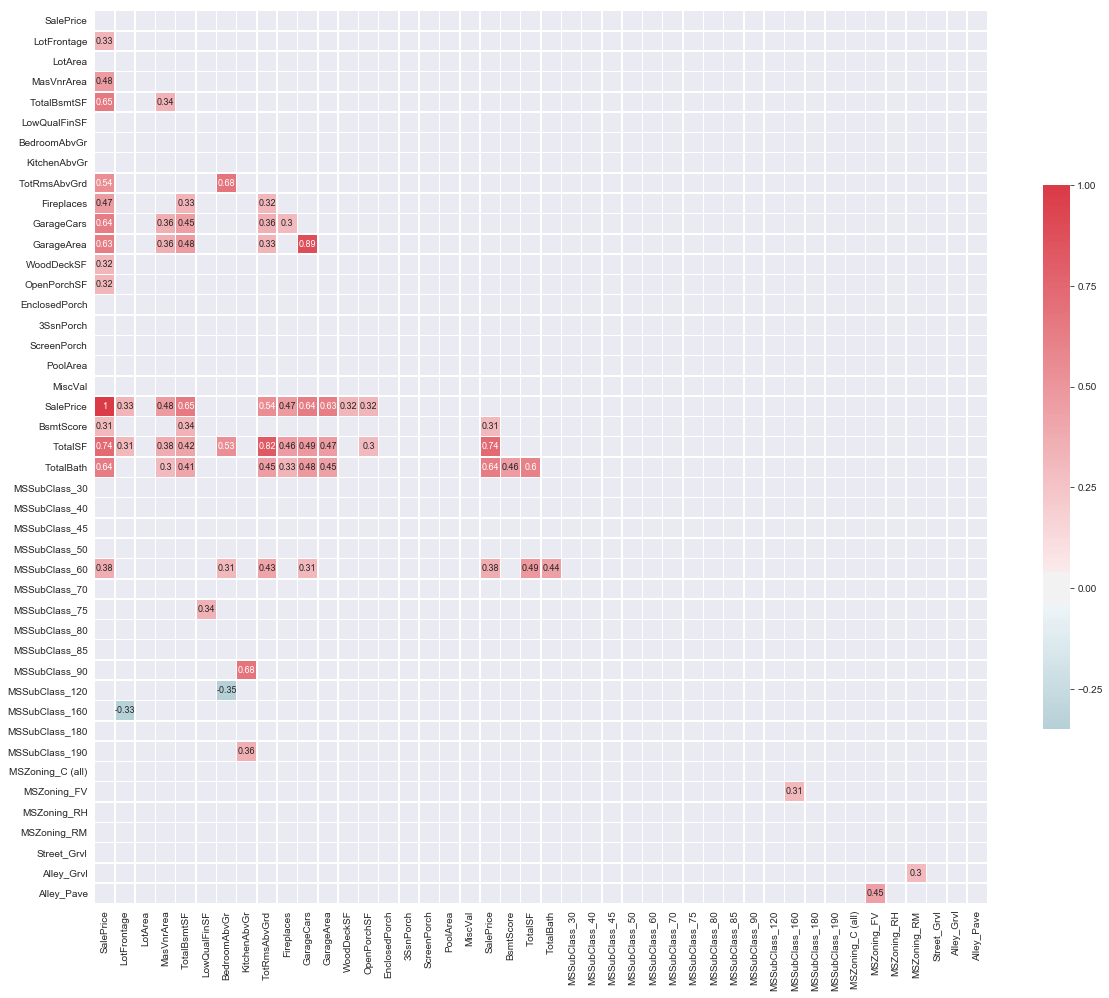

In [10]:
explore1 = train[['SalePrice', 'LotFrontage', 'LotArea', 'MasVnrArea', 'TotalBsmtSF', 'LowQualFinSF', 'BedroomAbvGr',
                  'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars','GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                  'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice', 'BsmtScore', 'TotalSF',
                  'TotalBath', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60',
                  'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120',
                  'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSZoning_C (all)', 'MSZoning_FV',
                  'MSZoning_RH', 'MSZoning_RM', 'Street_Grvl', 'Alley_Grvl', 'Alley_Pave']]
corr1 = explore1.corr()
f, ax = plt.subplots(figsize=(20,20))
mask = np.zeros_like(corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr1[(corr1 > 0.3)| (corr1 < -0.3)], mask=mask, cmap=cmap,
            xticklabels=corr1.columns.values,
            yticklabels=corr1.columns.values,
            center=0,
            square=True, linewidths=.5, annot=True, annot_kws={'size': 9}, cbar_kws={"shrink": .5})

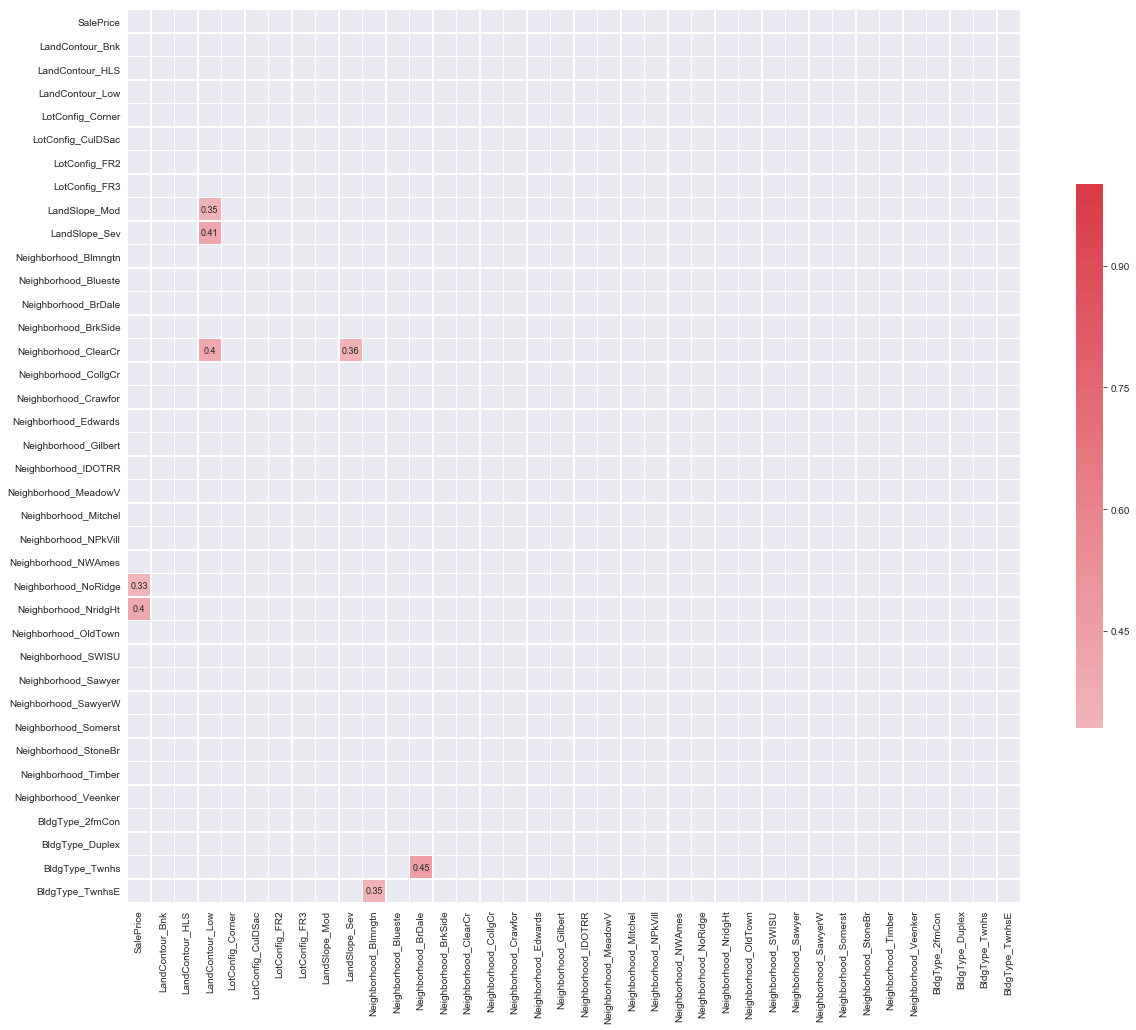

In [11]:
explore2 = train[['SalePrice', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LotConfig_Corner', 
                  'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LandSlope_Mod', 'LandSlope_Sev',
                  'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide',
                  'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards',
                  'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
                  'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
                  'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW',
                  'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker',
                  'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE']]
corr2 = explore2.corr()
f, ax = plt.subplots(figsize=(20,20))
mask = np.zeros_like(corr2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr2[(corr2 > 0.3)| (corr2 < -0.3)], mask=mask, cmap=cmap, 
            xticklabels=corr2.columns.values,
            yticklabels=corr2.columns.values,
            center=0,
            square=True, linewidths=.5, annot=True, annot_kws={'size': 9}, cbar_kws={"shrink": .5})

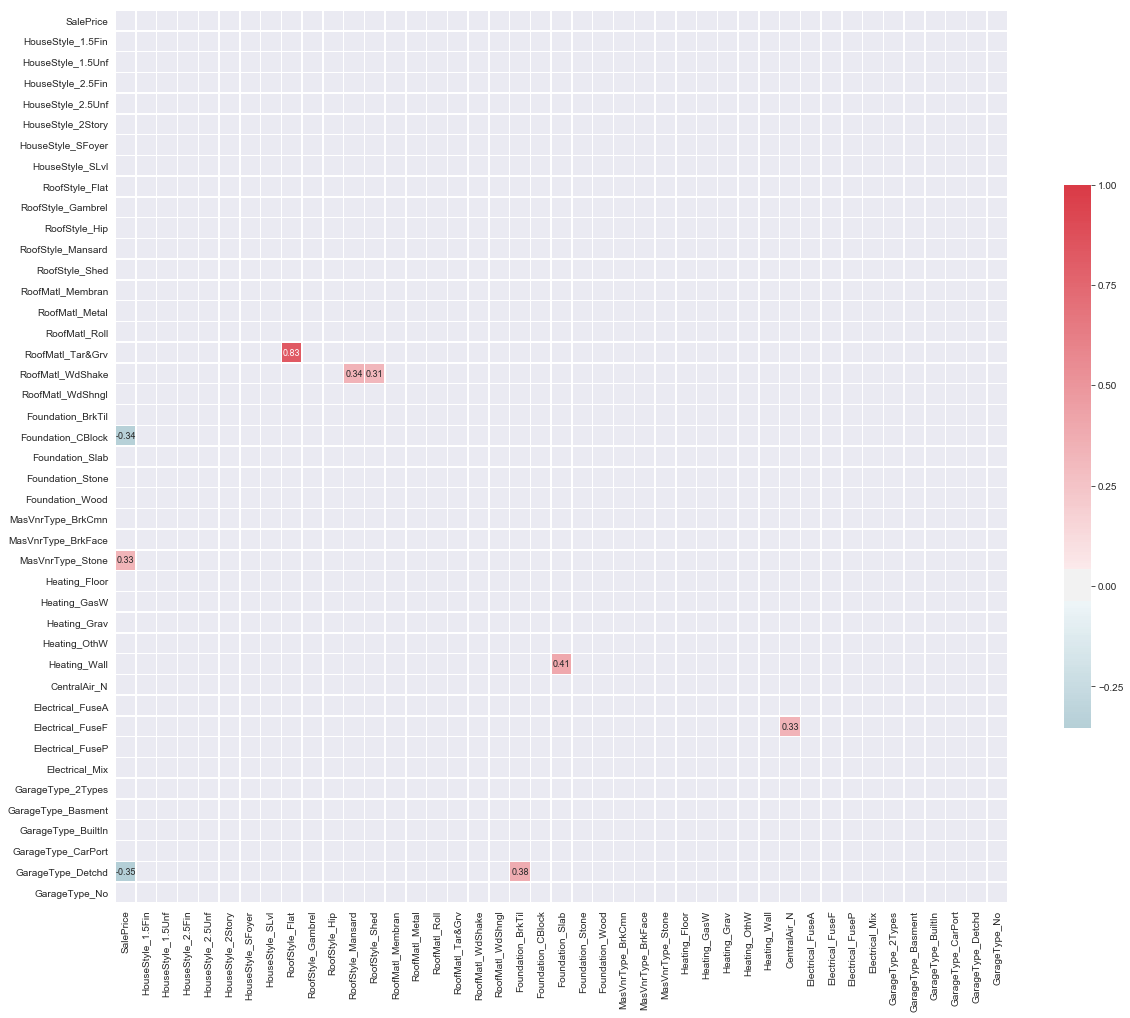

In [12]:
explore3 = train[['SalePrice','HouseStyle_1.5Fin', 'HouseStyle_1.5Unf', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf',
                  'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'RoofStyle_Flat', 'RoofStyle_Gambrel',
                  'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_Membran', 'RoofMatl_Metal',
                  'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Foundation_BrkTil',
                  'Foundation_CBlock', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'MasVnrType_BrkCmn',
                  'MasVnrType_BrkFace', 'MasVnrType_Stone', 'Heating_Floor', 'Heating_GasW', 'Heating_Grav',
                  'Heating_OthW', 'Heating_Wall', 'CentralAir_N', 'Electrical_FuseA', 'Electrical_FuseF',
                  'Electrical_FuseP', 'Electrical_Mix', 'GarageType_2Types', 'GarageType_Basment',
                  'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd', 'GarageType_No']]
 
corr3 = explore3.corr()
f, ax = plt.subplots(figsize=(20,20))
mask = np.zeros_like(corr3, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr3[(corr3 > 0.3)| (corr3 < -0.3)], mask=mask, cmap=cmap, 
            xticklabels=corr3.columns.values,
            yticklabels=corr3.columns.values,
            center=0,
            square=True, linewidths=.5, annot=True, annot_kws={'size': 9}, cbar_kws={"shrink": .5})

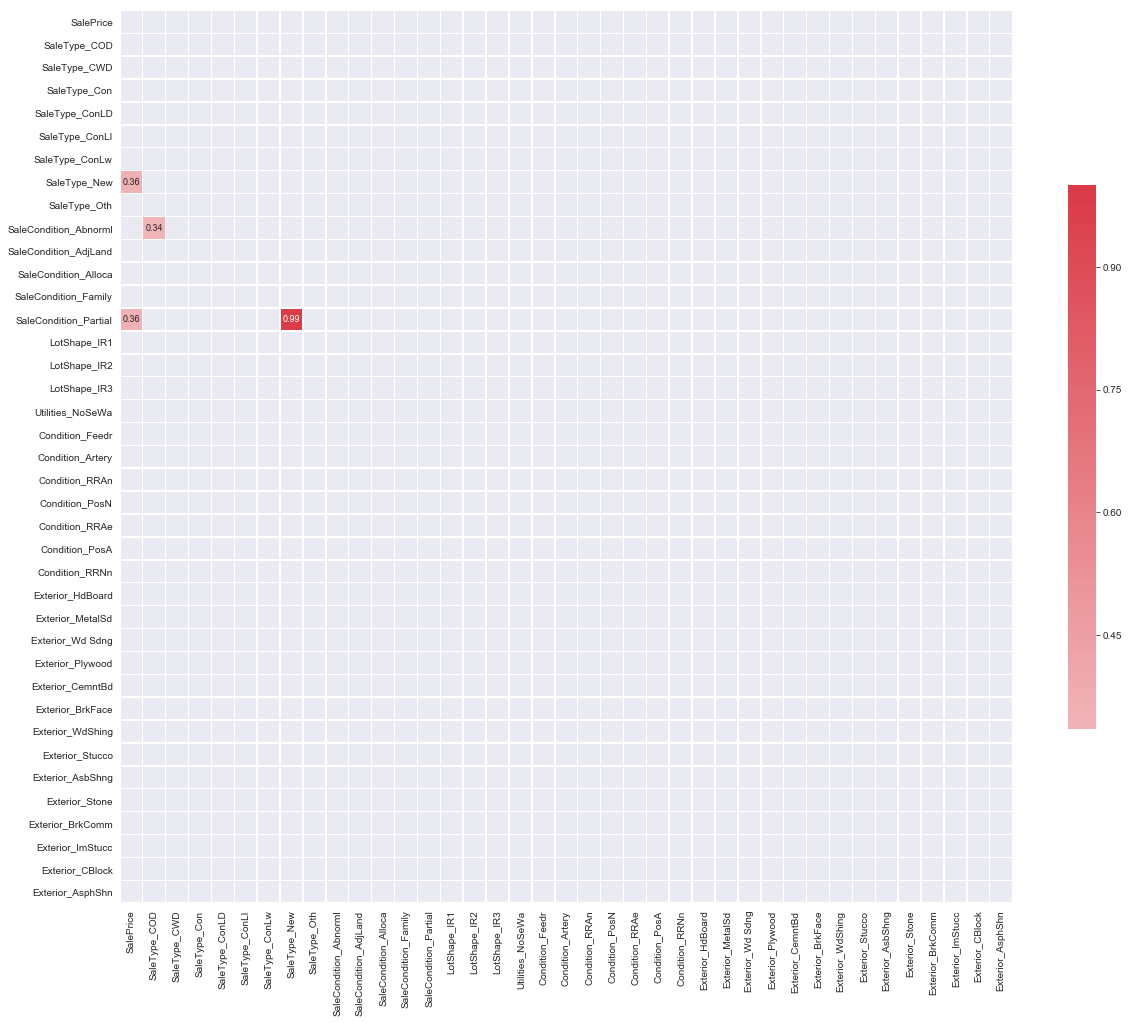

In [13]:
explore4 = train[['SalePrice', 'SaleType_COD', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI',
                  'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
                  'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Partial', 'LotShape_IR1',
                  'LotShape_IR2', 'LotShape_IR3', 'Utilities_NoSeWa', 'Condition_Feedr','Condition_Artery', 
                  'Condition_RRAn', 'Condition_PosN', 'Condition_RRAe', 'Condition_PosA', 'Condition_RRNn',
                  'Exterior_HdBoard', 'Exterior_MetalSd', 'Exterior_Wd Sdng', 'Exterior_Plywood',
                  'Exterior_CemntBd', 'Exterior_BrkFace', 'Exterior_WdShing', 'Exterior_Stucco', 'Exterior_AsbShng',
                  'Exterior_Stone', 'Exterior_BrkComm', 'Exterior_ImStucc', 'Exterior_CBlock', 'Exterior_AsphShn']]
corr4 = explore4.corr()
f, ax = plt.subplots(figsize=(20,20))
mask = np.zeros_like(corr4, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr4[(corr4 > 0.3)| (corr4 < -0.3)], mask=mask, cmap=cmap, 
            xticklabels=corr4.columns.values,
            yticklabels=corr4.columns.values,
            center=0,
            square=True, linewidths=.5, annot=True, annot_kws={'size': 9}, cbar_kws={"shrink": .5})

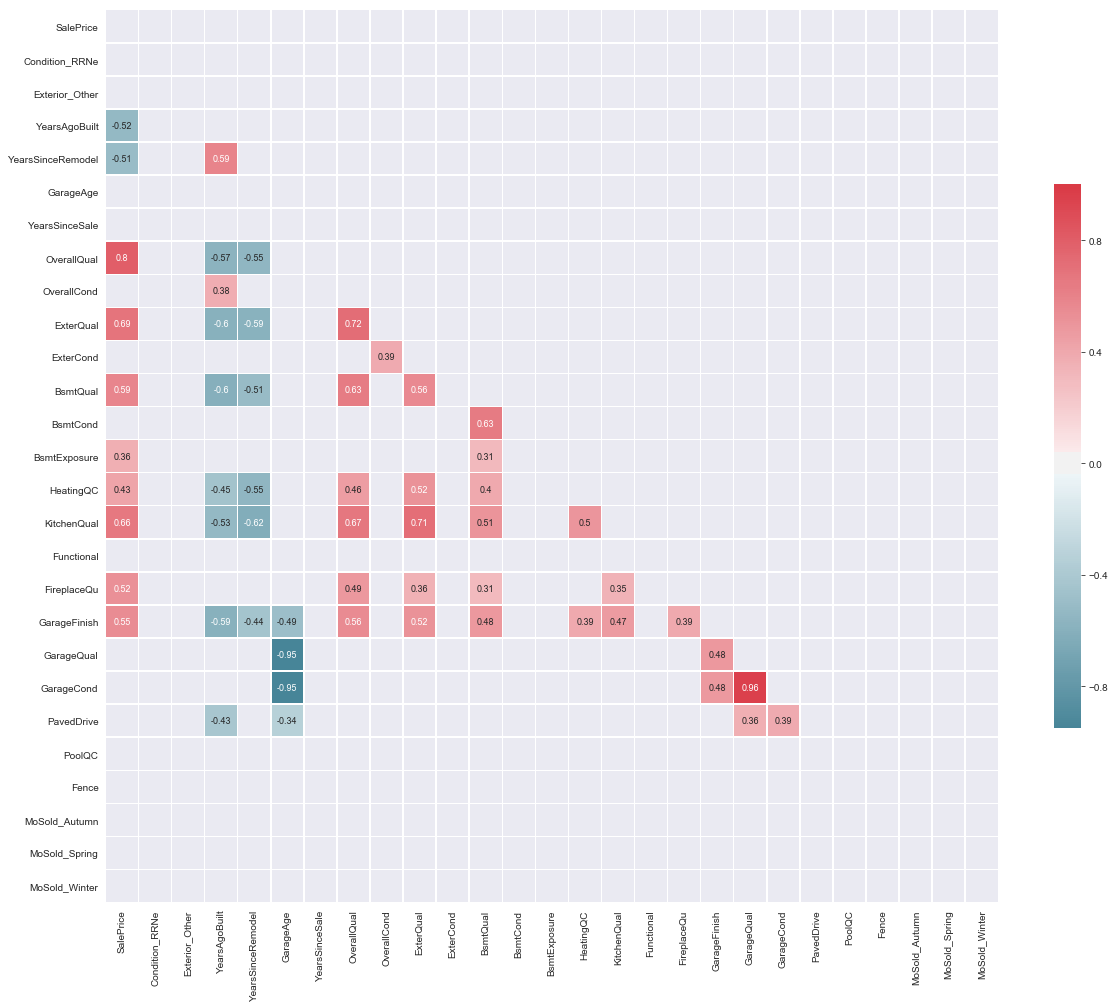

In [14]:
explore5 = train[['SalePrice', 'Condition_RRNe', 'Exterior_Other', 'YearsAgoBuilt', 'YearsSinceRemodel', 'GarageAge',
                  'YearsSinceSale', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                  'BsmtExposure', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish',
                  'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MoSold_Autumn', 'MoSold_Spring',
                  'MoSold_Winter']]
corr5 = explore5.corr()
f, ax = plt.subplots(figsize=(20,20))
mask = np.zeros_like(corr5, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr5[(corr5 > 0.3)| (corr5 < -0.3)], mask=mask, cmap=cmap, 
            xticklabels=corr5.columns.values,
            yticklabels=corr5.columns.values,
            center=0,
            square=True, linewidths=.5, annot=True, annot_kws={'size': 9}, cbar_kws={"shrink": .5})

###  Boosted Feature Selection
- A feature selection algorithm should ideally satisfy four conditions:
     - reliably extract relevant features; 
     - be able to identify non-linear feature interactions; 
     - scale linearly with the number of features and dimensions; 
     - allow the incorporation of known sparsity structure. 
     
- flexible, scalable, and surprisingly straight-forward to implement
- based on a modification of Gradient Boosted Trees. 



* 'Linear feature selection algorithms such as LARS are highly effective at discovering linear dependencies between features and labels. However, they fail when features interact in nonlinear ways. Nonlinear feature selection algorithms, such as Random Forest or recently introduced kernel methods, can cope with nonlinear interactions. But their computational and memory complexity typically grow super-linearly with the training set size. As data sets grow in size, this is increasingly problematic. Balancing the twin goals of scalability and nonlinear feature selection is still an open problem.'

ref: http://alicezheng.org/papers/gbfs.pdf

In [15]:
X = train.drop('SalePrice', axis = 1)
y = train['SalePrice']

### Random Forest Feature Selection

In [ ]:
randomForest = RandomForestRegressor()
grid_para_forest = [{
    "n_estimators": [250, 500],
    "min_samples_leaf": range(10,15),
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int),
    "random_state": [0, 19, 42]}]
%time
grid_search_forest = GridSearchCV(randomForest, grid_para_forest, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search_forest = grid_search_forest.fit(X, y)

In [ ]:
print("Best parameters found: ", grid_search_forest.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_search_forest.best_score_)))

In [ ]:
rf = pd.DataFrame(list(zip(X.columns, grid_search_forest.best_estimator_.feature_importances_ ))).set_index(0).sort_values(1, ascending=False)

In [ ]:
print(len(rf[rf[1] >= 0.0005].index))
rf[rf[1] >= 0.0005].index

In [39]:
print(len(rf[rf[1] >= 0.0005].index))
rf[rf[1] >= 0.0005].index

28


Index(['OverallQual', 'TotalSF', 'TotalBsmtSF', 'BsmtScore', 'TotalBath',
       'GarageArea', 'LotArea', 'GarageCars', 'YearsAgoBuilt', 'BsmtQual',
       'TotRmsAbvGrd', 'KitchenQual', 'ExterQual', 'YearsSinceRemodel',
       'MasVnrArea', 'GarageAge', 'GarageFinish', 'FireplaceQu',
       'GarageType_Detchd', 'CentralAir_N', 'LotFrontage', 'OverallCond',
       'WoodDeckSF', 'OpenPorchSF', 'BsmtExposure', 'MSZoning_RM',
       'GarageQual', 'LotShape_IR1'],
      dtype='object', name=0)

In [ ]:
rfFeat = pd.DataFrame(rf[rf[1] >= 0.0005])
rfFeat

### XGBoost Feature Selection

In [ ]:
# Feature selection
import xgboost as xgb
xgbforest = xgb.XGBRegressor()
grid_para_xgbforest = [{
    "colsample_bytree": np.linspace(0.1, 0.9, 9),
    'max_depth':[2, 4, 6, 8],
    'min_child_weight': [1, 5],
    'gamma': [0.1, 0.2],
    "n_estimators":[500, 800, 1000, 2000]}]

grid_search_xgbforest = GridSearchCV(estimator = xgbforest, param_grid = grid_para_xgbforest, scoring = 'neg_mean_squared_error', cv = 5, n_jobs=-1)
%time grid_search_xgbforest = grid_search_xgbforest.fit(X, y)

In [ ]:
print("Best parameters found: ", grid_search_xgbforest.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_search_xgbforest.best_score_)))

In [42]:
print("Best parameters found: ", grid_search_xgbforest.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_search_xgbforest.best_score_)))
Best parameters found:  {'colsample_bytree': 0.4, 'max_depth': 2, 'n_estimators': 800, 'random_state': 42}
Lowest RMSE found:  21350.378712255773s

Best parameters found:  {'colsample_bytree': 0.4, 'max_depth': 2, 'n_estimators': 800, 'random_state': 42}
Lowest RMSE found:  21350.378712255773


In [ ]:
xgb = pd.DataFrame(list(zip(X.columns, grid_search_xgbforest.best_estimator_.feature_importances_ ))).set_index(0).sort_values(1, ascending=False)

In [ ]:
print(len(xgb[xgb[1] >= 0.0025].index))
xgb[xgb[1] >= 0.0025].index

In [ ]:
xgbFeat = pd.DataFrame(xgb[xgb[1] >= 0.0025])
xgbFeat.head()

In [81]:
# xgbFeatures2 = xgbFeat.to_csv('xgbFeatures2.csv')
# xgbFeatRank = xgb.to_csv('xgbFeatRank.csv')
# comment to prevent overwriting final csv files in use

In [8]:
# Plot relative impotance of features from boosted feature engineering
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

rfFeat = pd.read_csv('../data/rfFeatures.csv')
xgbFeat = pd.read_csv('../data/xgbFeatures.csv')

def plot_importance(data):
    data.columns = ['Feature','Score']
    impt = data[::-1]
    plt.figure(figsize=(9,12))
    plt.title('Boosted Feature Selection')
    plt.barh(impt['Feature'], impt['Score'], align='center', color='b')
    plt.xlabel('Relative Importance')
    plt.ylabel('Feature')
    plt.show()

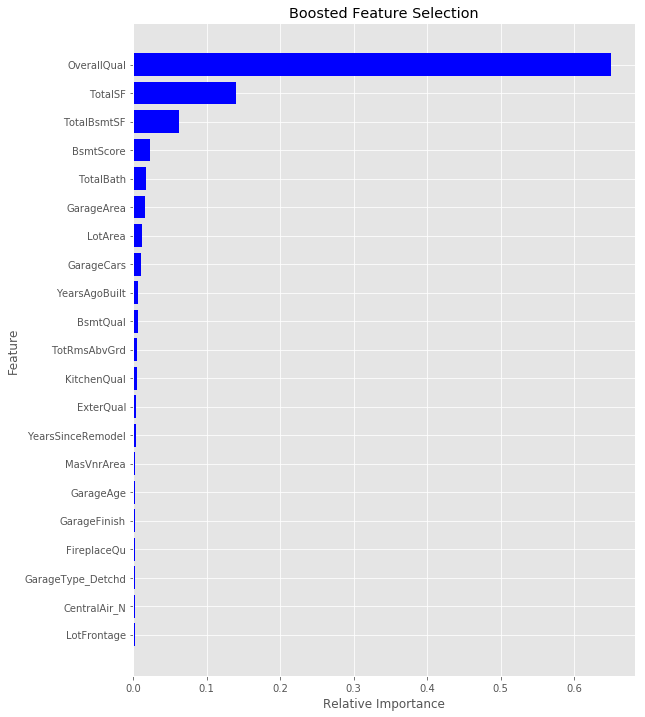

In [13]:
plot_importance(rfFeat[:21])

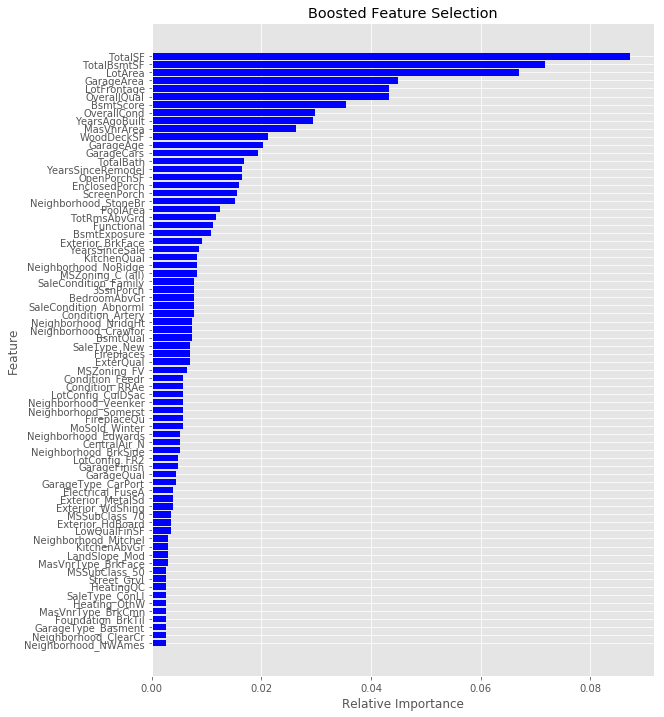

In [10]:
plot_importance(xgbFeat)

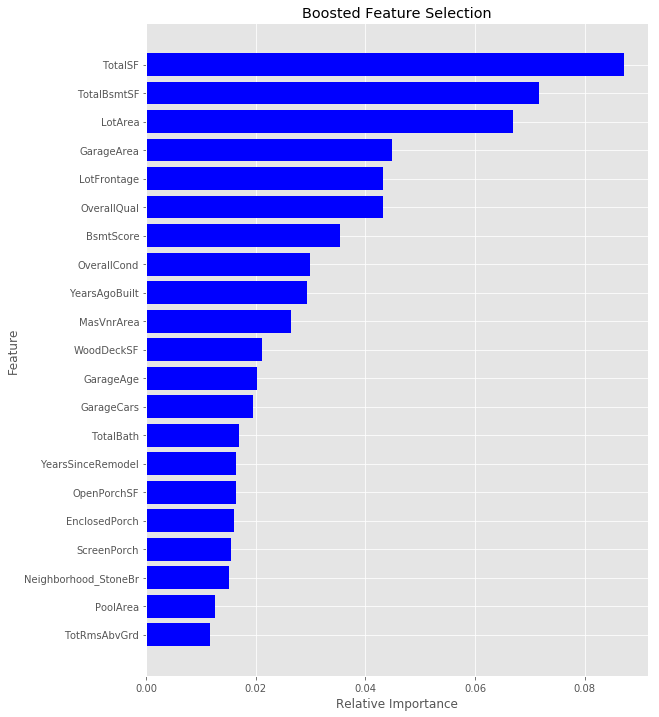

In [14]:
plot_importance(xgbFeat[:21])